This code is the last part of my project about Denoising Autoencoders. This part is more complicated than the previous ones because of the data. Now, I'm using Cifar100 dataset, the image's size is more or less the same, but these images are really different between them. Besides, these images are not in grayscale, they have three channels BGR.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt   

Load CIFAR100 dataset

In [ ]:
from keras.datasets import cifar100

(X_train, Y_train), (X_test, Y_test) = cifar100.load_data()

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


Split train set in two new sets: train and validation (30%)

(35000, 32, 32, 3)
(15000, 32, 32, 3)


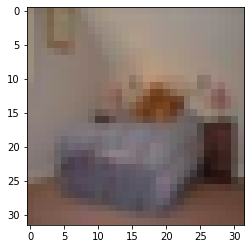

In [ ]:
from sklearn.model_selection import train_test_split

x_train_new, x_validation_new, y_train_new, y_validation_new = train_test_split(X_train, Y_train, test_size=15000, shuffle=True)

print(x_train_new.shape)
print(x_validation_new.shape)

plt.imshow(x_train_new[0])
plt.show()

Preprocess all the data and create the noisy dataset with noise_factor=0.15

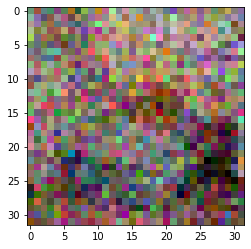

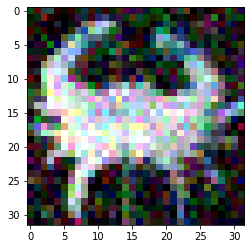

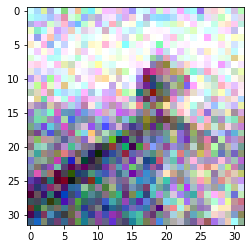

In [ ]:
x_train = x_train_new.astype('float32') / 255
x_validation = x_validation_new.astype('float32') / 255
x_test = X_test.astype('float32') / 255

noise_factor = 0.15
#we choose loc = 0 and scale = 1. We add noise to the original images.
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_validation_noisy = x_validation + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_validation.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

#limit the values between 0 and 1.
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_validation_noisy = np.clip(x_validation_noisy, 0., 1.)
x_test_small_noisy = np.clip(x_test_noisy, 0., 1.)

plt.imshow(x_train_noisy[0].reshape(32,32,3))
plt.show()
plt.imshow(x_validation_noisy[0].reshape(32,32,3))
plt.show()
plt.imshow(x_test_small_noisy[0].reshape(32,32,3))
plt.show()

Create U-NET model.

In [ ]:
def build_model(input_layer, start_neurons):
    conv1 = tf.keras.layers.Conv2D(start_neurons*1,(3,3), activation='relu', padding='same')(input_layer)
    conv1 = tf.keras.layers.Conv2D(start_neurons*1,(3,3), activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D((2,2))(conv1)
    pool1 = tf.keras.layers.Dropout(0.25)(pool1)
    
    conv2 = tf.keras.layers.Conv2D(start_neurons*2,(3,3), activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(start_neurons*2,(3,3), activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D((2,2))(conv2)
    pool2 = tf.keras.layers.Dropout(0.5)(pool2)

    conv3 = tf.keras.layers.Conv2D(start_neurons*4,(3,3), activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(start_neurons*4,(3,3), activation='relu', padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D((2,2))(conv3)
    pool3 = tf.keras.layers.Dropout(0.5)(pool3)
    
    conv4 = tf.keras.layers.Conv2D(start_neurons*8,(3,3), activation='relu', padding='same')(pool3)
    conv4 = tf.keras.layers.Conv2D(start_neurons*8,(3,3), activation='relu', padding='same')(conv4)
    pool4 = tf.keras.layers.MaxPooling2D((2,2))(conv4)
    pool4 = tf.keras.layers.Dropout(0.5)(pool4)

    #Middle
    convm = tf.keras.layers.Conv2D(start_neurons * 16, (3,3), activation='relu', padding='same')(pool4)
    convm = tf.keras.layers.Conv2D(start_neurons * 16, (3,3), activation='relu', padding='same')(convm)
    
    #upconv part
    deconv4 = tf.keras.layers.Conv2DTranspose(start_neurons*8,(3,3), strides=(2,2), padding='same')(convm)
    uconv4 = tf.keras.layers.concatenate([deconv4, conv4])
    uconv4 = tf.keras.layers.Dropout(0.5)(uconv4)
    uconv4 = tf.keras.layers.Conv2D(start_neurons*8, (3,3), activation='relu', padding='same')(uconv4)
    uconv4 = tf.keras.layers.Conv2D(start_neurons*8, (3,3), activation='relu', padding='same')(uconv4)
    
    deconv3 = tf.keras.layers.Conv2DTranspose(start_neurons*8,(3,3), strides=(2,2), padding='same')(uconv4)
    uconv3 = tf.keras.layers.concatenate([deconv3, conv3])
    uconv3 = tf.keras.layers.Dropout(0.5)(uconv3)
    uconv3 = tf.keras.layers.Conv2D(start_neurons*4, (3,3), activation='relu', padding='same')(uconv3)
    uconv3 = tf.keras.layers.Conv2D(start_neurons*4, (3,3), activation='relu', padding='same')(uconv3)
    
    deconv2 = tf.keras.layers.Conv2DTranspose(start_neurons*8,(3,3), strides=(2,2), padding='same')(uconv3)
    uconv2 = tf.keras.layers.concatenate([deconv2, conv2])
    uconv2 = tf.keras.layers.Dropout(0.5)(uconv2)
    uconv2 = tf.keras.layers.Conv2D(start_neurons*2, (3,3), activation='relu', padding='same')(uconv2)
    uconv2 = tf.keras.layers.Conv2D(start_neurons*2, (3,3), activation='relu', padding='same')(uconv2)
    
    deconv1 = tf.keras.layers.Conv2DTranspose(start_neurons*8,(3,3), strides=(2,2), padding='same')(uconv2)
    uconv1 = tf.keras.layers.concatenate([deconv1, conv1])
    uconv1 = tf.keras.layers.Dropout(0.5)(uconv1)
    uconv1 = tf.keras.layers.Conv2D(start_neurons*1, (3,3), activation='relu', padding='same')(uconv1)
    uconv1 = tf.keras.layers.Conv2D(start_neurons*1, (3,3), activation='relu', padding='same')(uconv1)
    
    output_layer = tf.keras.layers.Conv2D(3, (1,1), padding='same', activation='sigmoid')(uconv1)
    return output_layer

Compile the model.

In [ ]:
input_layer = tf.keras.layers.Input((32, 32, 3))
output_layer = build_model(input_layer, 64)


model_unet = tf.keras.Model(input_layer, output_layer)
model_unet.compile(optimizer='adam', loss='MSE')
model_unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 32, 32, 64)   1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 32, 32, 64)   36928       conv2d_38[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 16, 16, 64)   0           conv2d_39[0][0]                  
____________________________________________________________________________________________

Training

In [ ]:
model = model_unet.fit(x_train_noisy, x_train, validation_data=(x_validation_noisy, x_validation), 
                                        epochs=35, shuffle=True, batch_size=128)

Epoch 1/35
274/274 [==============================] - 122s 440ms/step - loss: 0.0174 - val_loss: 0.0033
Epoch 2/35
274/274 [==============================] - 121s 442ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 3/35
274/274 [==============================] - 121s 442ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 4/35
274/274 [==============================] - 121s 442ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 5/35
274/274 [==============================] - 121s 442ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 6/35
274/274 [==============================] - 121s 441ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 7/35
274/274 [==============================] - 121s 441ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 8/35
274/274 [==============================] - 121s 441ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 9/35
274/274 [==============================] - 121s 442ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 10/35
274/274 [==============================] - 121s 441m

Training history

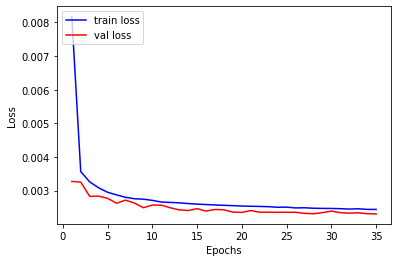

In [ ]:
loss_train = model.history['loss']
loss_val = model.history['val_loss']

t = np.linspace(1, 35, 35)

plt.plot(t, loss_train, "-b", label="train loss")
plt.plot(t, loss_val, "-r", label="val loss")
plt.legend(loc="upper left")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

Predictions: original vs predictions

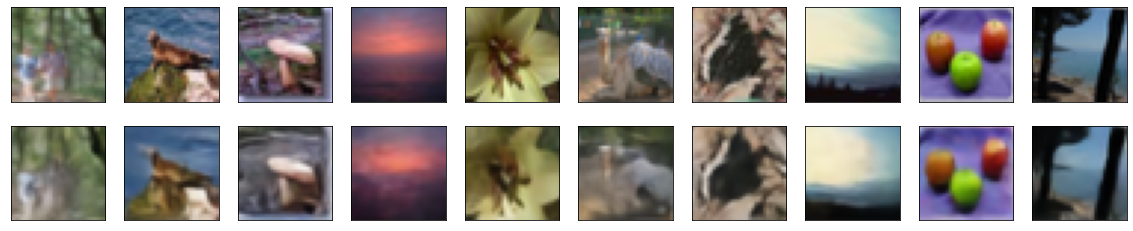

In [ ]:
#predictions
pred_unet = model_unet.predict(x_test_small_noisy)

#visualizating the predictions
samples = 10
plt.figure(figsize=(20, 4))

for i in range(1, samples + 1):
  #original image
  ax = plt.subplot(2, samples, i)
  plt.imshow(x_test[i].reshape(32, 32,3))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # Display reconstruction
  ax = plt.subplot(2, samples, i + samples)
  plt.imshow(pred_unet[i].reshape(32, 32,3))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()


Noise vs predictions

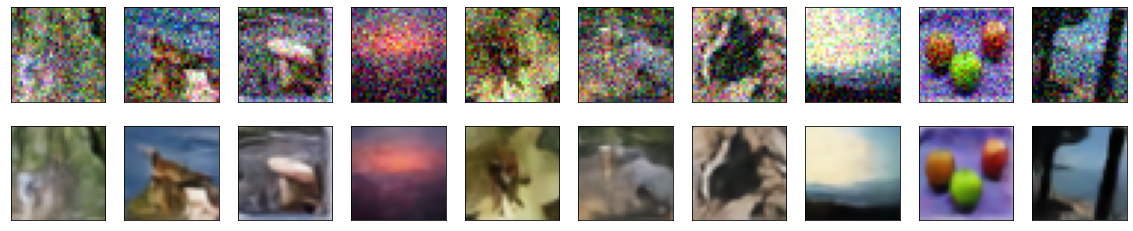

In [ ]:
samples = 10
plt.figure(figsize=(20, 4))
for i in range(1, samples + 1):
  #original image
  ax = plt.subplot(2, samples, i)
  plt.imshow(x_test_small_noisy[i].reshape(32, 32,3))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # Display reconstruction
  ax = plt.subplot(2, samples, i + samples)
  plt.imshow(pred_unet[i].reshape(32, 32,3))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

SSIM

In [ ]:
from skimage.measure import compare_ssim, compare_psnr
from skimage import data, img_as_float

compare_ssim(x_test, pred_unet, multichannel=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  after removing the cwd from sys.path.


0.9768414729385269